In [1]:
import time
import torch
from torch import distributions as D
from matplotlib import pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm

In [2]:
# Hack to import from a parent directory
import sys, os
path = '..'
if path not in sys.path:
    sys.path.append(path)

from LogitNormal import *
from TruncatedNormal import *
from mean_field import *
from obs_and_flow import *

## Generate data

Given fixed hyperparameters $\mu_\theta, \sigma_\theta, a, b, \mu_{x_0}, \sigma_x, \sigma_y$ and observed $y$, consider the following toy model:
- $\theta_0, \theta_1 \sim \text{LogitNormal}(\mu_\theta, \sigma_\theta, a, b)$
- $x_0 \sim N(\mu_{x_0}, \sigma_x)$
- $x_t \sim N(\theta_0+\theta_1x_{t-1}, \sigma_x)$
- $y_{t'} \sim N(x_{t'}, \sigma_y)$, where $t'$ is observed time steps

In [3]:
def generate_data(N, T, dt, mu_theta, sigma_theta, a_theta, b_theta,
                  mu_x, sigma_x, sigma_y, theta=None, obs_every=None):
    torch.manual_seed(0)
    if obs_every is None:
        obs_every = dt
    #assert obs_every % dt == 0, 'obs_every must be divisible by dt'
    obs_every_step = int(obs_every / dt)
    
    # Sample theta
    p_theta = RescaledLogitNormal(mu_theta, sigma_theta, a=a_theta, b=b_theta)
    if theta is None: # else use given theta
        theta = p_theta.sample() # (2, )
    
    # Allocate x tensor
    M = int(T / dt) + 1
    x = torch.empty((N, M)) # N - number of independent sequences; M - length of each sequence
    
    # Sample x0
    p_x0 = D.normal.Normal(mu_x, sigma_x)
    x[:, 0] = p_x0.sample((N, )) # (N, )
    #print('x_{}: {}'.format(0, x[:, 0]))
    
    # Sample x_t, t > 0
    for i in range(1, M):
        #print('theta0, theta1, prev, mu, sigma:', theta[0], theta[1], x[:, i - 1], theta[0] + theta[1] * x[:, i - 1], sigma_x)
        p_xt = D.normal.Normal(theta[0] + theta[1] * x[:, i - 1], sigma_x)
        
        # Draw sample
        x[:, i] = p_xt.sample() # (N, )
        #print('x_{}: {}'.format(i, x[:, i]))
    
    # Sample y
    x_for_y = x[:, ::obs_every_step]
    p_y = D.normal.Normal(x_for_y, sigma_y)
    y = p_y.sample() # (N, M_obs)
    
    # Observation timestamp t_y
    t_x = torch.arange(0, T + dt, dt)
    t_y = torch.arange(0, T + dt, obs_every)
    assert(len(t_y) == y.shape[1] and t_y[-1] == T)
    y_dict = {'t_y': t_y, 'y': y, 'sigma_y': sigma_y}
    
    return p_theta, theta, p_x0, x, y_dict

In [4]:
# theta hyperparameters
mu_theta = torch.tensor([0., 0.5])
sigma_theta = torch.tensor([1., 1.])
a_theta = torch.tensor([-2., -1.])
b_theta = torch.tensor([2., 1.])
theta = torch.tensor([0.6, 0.9])

# x hyperparameters
mu_x = torch.tensor(0.)
sigma_x = torch.tensor(0.8)

# y hyperparameter
sigma_y = torch.tensor(1.)

In [5]:
N, T, dt, obs_every = 1, 1000, 1.0, 10
p_theta, theta, p_x0, x, y_dict = generate_data(N, T, dt, mu_theta, sigma_theta, a_theta, b_theta,
                                                mu_x, sigma_x, sigma_y, obs_every=obs_every, theta=theta)

In [ ]:
p_theta1, theta1, p_x01, x1, y_dict1 = generate_data(N, T, 0.1, mu_theta, sigma_theta, a_theta, b_theta,
                                                mu_x, sigma_x, sigma_y, obs_every=obs_every, theta=theta)

In [ ]:
theta # needs to be between (-1, 1)

## Plot data

In [6]:
def plot_theta(p_theta, theta, num_pts=1000, eps=1e-6):
    fig, axes = plt.subplots(1, 3, figsize=(4*3, 4))
    
    a, b = p_theta.a, p_theta.b
    theta_range = torch.from_numpy(np.linspace(a + eps, b - eps, num_pts)).float()
    
    pdf_prior = torch.exp(p_theta.log_prob(theta_range)).detach()
    approx_int_prior = pdf_prior.sum(0) * (b - a) / num_pts
    assert torch.allclose(approx_int_prior, torch.tensor(1.0), rtol=1e-3)
    
    labels = ['$\\theta_0$', '$\\theta_1$']
    for i, ax in enumerate(axes):
        if i < 2:
            ax.plot(theta_range[:, i], pdf_prior[:, i], linewidth=2, label='prior')
            ax.axvline(theta[i], color='gray', label='true $\\theta$')
            ax.set_xlabel(labels[i])
            if i == 0: ax.set_ylabel('density')
        else:
            handles, labels = axes[0].get_legend_handles_labels()
            ax.legend(handles, labels, loc='center left')
            ax.axis('off')
    plt.tight_layout()

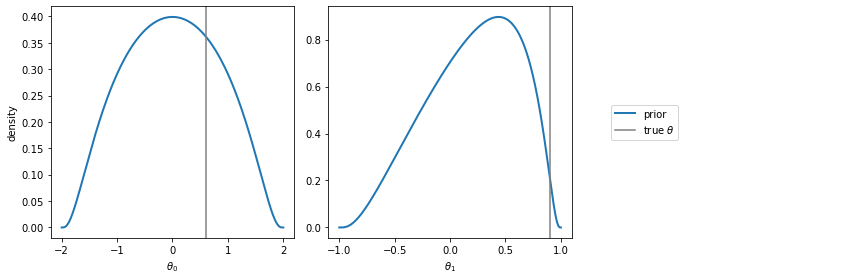

In [7]:
plot_theta(p_theta, theta)

In [8]:
def plot_path(x, y, t_x, t_y, title=None, state_dim=1):
    N, time_steps = x.shape
    fig, axes = plt.subplots(state_dim, figsize=(15, 4*state_dim), sharex=True)
    axes = np.atleast_1d(axes)
    
    for i, ax in enumerate(axes):            
        ax.plot(t_x, x[i, :], label='latent state')
        ax.plot(t_y, y[i, :], label='observation', linestyle='', marker='o')        
        ax.legend()
        if i == 0 and title:
            ax.set_title(title)
    ax.set_xlabel('hour')
    plt.tight_layout()

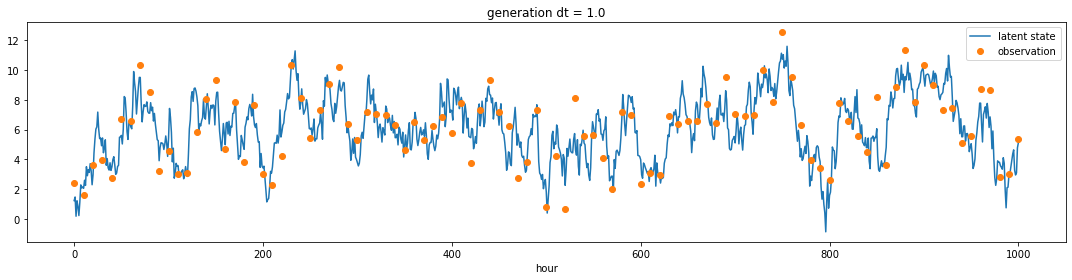

In [9]:
y, t_y = y_dict['y'], y_dict['t_y']
t_x = torch.arange(0, T + dt, dt)
plot_path(x, y, t_x, t_y, title='generation dt = 1.0')

In [ ]:
y1, t_y1 = y_dict1['y'], y_dict1['t_y']
t_x1 = torch.arange(0, T + 0.1, 0.1)
plot_path(x1, y1, t_x1, t_y1, title='generation dt = 0.1')

## Inference

Objective:
$$
\begin{align}
\mathcal{L} &= \frac{1}{S} \sum_s \left[ \log p(\theta, x, y) - \log q(\theta, x|y) \right] \\
  &= \frac{1}{S} \sum_s \left[\log p(\theta^{(s)}) - \log q(x^{(s)}) + \frac{T}{M} \left( \log p(x^{(s)}|\theta^{(s)}) + \log p(y|x^{(s)}) - \log q(\theta^{(s)}) \right) \right]
\end{align}
$$
where $T$ is the total number of time steps and $M$ is the minibatch size.

In [10]:
active_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.set_printoptions(precision = 8)

# Neural SDE parameters
dt_flow = 1.0 # [1.0, 0.5]
M = int(T / dt_flow) + 1

# Theta info
theta_dist = 'RescaledLogitNormal' #String needs to be exact name of the distribution class. Other option is 'RescaledLogitNormal'.
theta_post_dist = 'MultivariateLogitNormal'
param_names = ['theta_0', 'theta_1']
theta_hyperparams = {k: (loc, scale, a, b) for k, loc, scale, a, b in zip(param_names, mu_theta, sigma_theta, a_theta, b_theta)}
target_hyperparams = {k: (mean, sd, a, b) for k, mean, sd, a, b in zip(param_names, p_theta.mean, p_theta.stddev, a_theta, b_theta)}
fix_theta_dict = {'sigma_x': sigma_x}

In [11]:
def calc_log_lik(X, PARAMS_DICT, DT, X0_PRIOR):
    # X.shape == (batch_size, time_steps, state_dim)
    theta0, theta1 = PARAMS_DICT['theta_0'].reshape(-1, 1, 1), PARAMS_DICT['theta_1'].reshape(-1, 1, 1)
    loc, scale = theta0 + theta1 * X[:, :-1, :], PARAMS_DICT['sigma_x'].reshape(1, 1, 1)
    p_x = D.normal.Normal(loc, scale) 
    
    # Compute log p(x|theta) = log p(x|x0, theta) + log p(x0|theta)
    ll = p_x.log_prob(X[:, 1:, :]).sum((-2, -1)) # log p(x|x0, theta)
    ll += X0_PRIOR.log_prob(X[:, 0, :]).sum(-1) # log p(x0|theta)

    return ll # ll.shape == (batch_size, )

In [12]:
def train(DEVICE, NET_LR: float, THETA_LR: float, ELBO_ITER: int, BATCH_SIZE: int,
        DATA: dict, T: float, DT: float, N: int,
        X0_PRIOR: torch.distributions.distribution.Distribution,
        PRIOR_DIST_DETAILS_DICT: dict, 
        THETA_DIST = None, THETA_POST_DIST = None, THETA_POST_INIT = None,
        ELBO_LR_DECAY: float = 0.8, ELBO_DECAY_STEP_SIZE: int = 50000, 
        PRINT_EVERY: int = 100, FIX_THETA_DICT: dict = None,
        NUM_LAYERS: int = 5, KERNEL_SIZE: int = 3, NUM_RESBLOCKS: int = 2, REVERSE: bool = False):
    torch.manual_seed(seed)
    print('seed', seed)
    obs_dim, state_dim = 1, 1
    
    #Read in data to obtain y and establish observation model.
    obs_times, obs_vals, obs_error = np.array(DATA['t_y']), DATA['y'], DATA['sigma_y']
    obs_model = ObsModel(DEVICE, TIMES = obs_times, DT = DT, MU = obs_vals, SCALE = obs_error)

    #Establish neural network.
    net = SDEFlow(DEVICE, obs_model, state_dim, T, DT, N, num_layers = NUM_LAYERS, positive = False, reverse = REVERSE)
    
    param_names = list(PRIOR_DIST_DETAILS_DICT.keys())

    #Convert prior details dictionary values to tensors.
    prior_list = list(zip(*(PRIOR_DIST_DETAILS_DICT[k] for k in param_names))) #Unzip prior distribution details from dictionary values into individual lists.
    prior_means_tensor, prior_sds_tensor, prior_lowers_tensor, prior_uppers_tensor = torch.tensor(prior_list).to(DEVICE) #Ensure conversion of lists into tensors.

    #Retrieve desired distribution class based on string.
    dist_class_dict = {
            'TruncatedNormal': TruncatedNormal,
            'RescaledLogitNormal': RescaledLogitNormal,
            'MultivariateLogitNormal': MultivariateLogitNormal
            }
    THETA_PRIOR_CLASS = dist_class_dict[THETA_DIST]
    THETA_POST_CLASS = dist_class_dict[THETA_POST_DIST] if THETA_POST_DIST else dist_class_dict[THETA_DIST]
    
    #Define prior
    p_theta = THETA_PRIOR_CLASS(loc = prior_means_tensor, scale = prior_sds_tensor, a = prior_lowers_tensor, b = prior_uppers_tensor)

    # Initialize posterior q(theta) using its prior p(theta)
    learn_cov = (THETA_POST_DIST == 'MultivariateLogitNormal')
    if THETA_POST_INIT is None:
        THETA_POST_INIT = PRIOR_DIST_DETAILS_DICT
    q_theta = MeanField(DEVICE, param_names, THETA_POST_INIT, THETA_POST_CLASS, learn_cov)

    #Record loss throughout training
    #best_loss_norm = 1e15
    #best_loss_ELBO = 1e15
    #norm_losses = []
    ELBO_losses = []
    means_hist = []
    sds_hist = []

    #Initiate optimizers.
    #ELBO_params = list(net.parameters()) + list(q_theta.parameters())
    #ELBO_optimizer = optim.Adamax(ELBO_params, lr = ELBO_LR)
    net_optimizer = optim.Adamax(net.parameters(), lr = NET_LR)
    theta_optimizer = optim.Adamax(q_theta.parameters(), lr = THETA_LR)

    net.train()
    with tqdm(total = ELBO_ITER, desc = f'Learning SDE and hidden parameters.', position = -1) as tq:
        for it in range(ELBO_ITER + 1):
            # Sample (unknown) theta
            theta_dict, theta, log_q_theta, parent_loc_scale_dict = q_theta(BATCH_SIZE)
            #assert log_q_theta.shape == (BATCH_SIZE, )
            
            log_p_theta = p_theta.log_prob(theta).sum(-1)
            #assert log_p_theta.shape == (BATCH_SIZE, )
            
            # Fix known theta
            if FIX_THETA_DICT:
                theta_dict = {**theta_dict, **FIX_THETA_DICT}

            # Sample x
            C_PATH, log_prob = net(BATCH_SIZE) #Obtain paths with solutions to times including t0.
            #assert log_prob.shape == (BATCH_SIZE, 1)
            #print(C_PATH.shape, log_prob.shape)
            
            # Zero gradients
            #ELBO_optimizer.zero_grad()
            net_optimizer.zero_grad()
            theta_optimizer.zero_grad()

            # Compute likelihood and ELBO
            # Negative ELBO: -log p(theta) + log q(theta) - log p(y_0|x_0, theta) + log q(x|theta) - log p(x|theta) - log p(y|x, theta)
            log_lik = calc_log_lik(C_PATH, theta_dict, DT, X0_PRIOR)
            #assert log_lik.shape == (BATCH_SIZE, )
            
            log_p_obs_mean = obs_model(C_PATH, theta_dict)
            #assert log_p_obs_mean.shape == ()
            
            ELBO = -log_p_theta.mean() + log_q_theta.mean() + log_prob.mean() - log_lik.mean() - log_p_obs_mean
            #print(log_p_theta.mean(), log_q_theta.mean(), log_prob.mean(), log_lik.mean(), obs_model(C_PATH, theta_dict))
            
            # Record ELBO history and best ELBO so far
            ELBO_losses.append(ELBO.item())

            # Print info
            if it % PRINT_EVERY == 0:
                #k = min(100, it + 1)
                #ma_loss = sum(ELBO_losses[-k:]) / len(ELBO_losses[-k:])
                #print('Iteration {} moving average loss: {}'.format(it + 1, ma_loss))
                print('Iteration {} full unibatch loss: {}'.format(it, ELBO_losses[-1]))
            
            # Take gradient step
            if it < ELBO_ITER:
                ELBO.backward()
                torch.nn.utils.clip_grad_norm_(net.parameters(), 5.0)
                torch.nn.utils.clip_grad_norm_(q_theta.parameters(), 5.0)
                #ELBO_optimizer.step()
                net_optimizer.step()
                theta_optimizer.step()
                
            if ELBO_ITER - 1000 <= it < ELBO_ITER:
                # Record theta parameter values
                means_hist.append(torch.clone(q_theta.means))
                sds_hist.append(torch.clone(q_theta.sds))

            if it > 0 and it % ELBO_DECAY_STEP_SIZE == 0:
                #ELBO_optimizer.param_groups[0]['lr'] *= ELBO_LR_DECAY
                net_optimizer.param_groups[0]['lr'] *= ELBO_LR_DECAY
                theta_optimizer.param_groups[0]['lr'] *= ELBO_LR_DECAY

            tq.update()

    print('\nAll finished! Now, we need to check outputs to see if things worked...')
    
    return net, q_theta, p_theta, obs_model, ELBO_losses, means_hist, sds_hist # losses_full, times

In [13]:
#Training parameters
niter = 3000 # niter = epochs * (m - 1) / minibatch_size
net_lr, theta_lr = 0.01, 0.01 #ELBO learning rate
batch_size = 20 #3 - number needed to fit UCI HPC3 RAM requirements with 16 GB RAM at t = 5000.
seed = 1

In [14]:
net_rev, q_theta_raw_rev, p_theta_rev, obs_model_rev, losses_rev, means_rev, sds_rev = train(
    active_device, net_lr, theta_lr, niter, batch_size,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist,
    ELBO_LR_DECAY = 1.0, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict, REVERSE=True)

seed 1


Iteration 0 full unibatch loss: 43292.8203125
Iteration 300 full unibatch loss: 286.4199523925781
Iteration 600 full unibatch loss: 204.71083068847656
Iteration 900 full unibatch loss: 175.93063354492188
Iteration 1200 full unibatch loss: 161.4708251953125
Iteration 1500 full unibatch loss: 151.9969024658203
Iteration 1800 full unibatch loss: 150.230224609375
Iteration 2100 full unibatch loss: 140.91445922851562
Iteration 2400 full unibatch loss: 130.7108917236328
Iteration 2700 full unibatch loss: 130.16543579101562
Iteration 3000 full unibatch loss: 131.18844604492188


All finished! Now, we need to check outputs to see if things worked...


In [ ]:
net_high, q_theta_raw_high, p_theta_high, obs_model_high, losses_high, means_high, sds_high = train(
    active_device, 0.01, 0.01, niter, batch_size,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist,
    ELBO_LR_DECAY = 1.0, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict)

In [ ]:
net, q_theta_raw, p_theta, obs_model, losses = train(
    active_device, net_lr, theta_lr, niter, batch_size,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist,
    ELBO_LR_DECAY = 1.0, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict)

In [ ]:
net_high, q_theta_raw_high, p_theta_high, obs_model_high, losses_high = \
    net1, q_theta_raw1, p_theta1, obs_model1, losses1

In [ ]:
net_high_decay, q_theta_raw_high_decay, p_theta_high_decay, obs_model_high_decay, losses_high_decay = train(
    active_device, 0.01, 0.01, 3000, batch_size,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist,
    ELBO_LR_DECAY = 0.1, ELBO_DECAY_STEP_SIZE = 1000, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict)

In [ ]:
net2, q_theta_raw2, p_theta2, obs_model2, losses2 = train(
    active_device, 0.01, 0.1, niter, batch_size,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist,
    ELBO_LR_DECAY = 1.0, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict)

In [ ]:
net3, q_theta_raw3, p_theta3, obs_model3, losses3 = train(
    active_device, 0.1, 0.1, niter, batch_size,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist,
    ELBO_LR_DECAY = 1.0, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict)

In [ ]:
net_lo_la, q_theta_raw_lo_la, p_theta_lo_la, obs_model_lo_la, losses_lo_la = train(
    active_device, 0.001, 0.01, niter, 30,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist, 
    ELBO_LR_DECAY = 1.0, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict)

In [ ]:
# Lower lr, smaller sample size, longer iterations
niter = 2000
net_lo_long, q_theta_raw_lo_long, p_theta_lo_long, obs_model_lo_long, losses_lo_long = train(
    active_device, 0.001, 0.01, niter, 20,
    y_dict, T, dt_flow, M, p_x0, theta_hyperparams,
    THETA_DIST = theta_dist, THETA_POST_DIST = theta_post_dist, 
    ELBO_LR_DECAY = 1.0, PRINT_EVERY = max(1, niter // 10), 
    FIX_THETA_DICT = fix_theta_dict)

In [ ]:
net_low, q_theta_raw_low, p_theta_low, obs_model_low, losses_low = \
    net_lo_long, q_theta_raw_lo_long, p_theta_lo_long, obs_model_lo_long, losses_lo_long

## Plot loss

In [18]:
def plot_loss(loss_hist_list, labels, time_hist_list=None, xscale='linear', ymin=None, ymax=None):
    plt.rcParams.update({'font.size': 12, 'lines.linewidth': 2, 'figure.figsize': (8, 6)})
    
    colors = [cm.tab10(i+1) for i in range(len(labels))]
    for loss_hist, label, color in zip(loss_hist_list, labels, colors):
        plt.plot(loss_hist, label=label, color=color)
    
    #plt.title('Loss v epoch')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.xscale(xscale)
    plt.ylim((ymin, ymax))

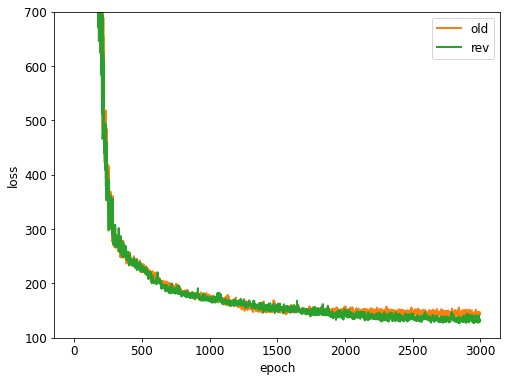

In [20]:
labels = ['old', 'rev'] # , 'mean-field'
plot_loss([losses_old[:3000], losses_rev], labels, ymax=700, ymin=100) # , losses_mf

In [ ]:
labels = ['lr=(0.001, 0.01), S=20', 'lr=(0.01, 0.01), S=20', 'lr=(0.01, 0.1), S=20', 'lr=(0.1, 0.1), S=20'] # , 'mean-field'
plot_loss([losses, losses1, losses2, losses3], labels, ymax=700, ymin=100) # , losses_mf

In [ ]:
labels = ['lr=(0.01, 0.01), S=20', 'lr=(0.001, 0.01), S=20', 'lr=(0.01, 0.01), S=30', 'lr=(0.001, 0.01), S=30'] # , 'mean-field'
plot_loss([losses, losses_lo, losses_la, losses_lo_la], labels, ymax=700, ymin=575) # , losses_mf

In [ ]:
# Extracts the distribution from a MeanField object
def extract_dist(q):
    a, b = q.lowers, q.uppers
    loc = q.means
    if not q.learn_cov:
        scale = torch.max(q.sds, torch.ones([]) * 1e-8)
        #scale = D.transform_to(q.dist.arg_constraints['scale'])(q.sds)
        return q.dist(loc, scale=scale, a=a, b=b)
    else:
        scale = D.transform_to(q.dist.arg_constraints['scale_tril'])(q.sds)
        return q.dist(loc, scale_tril=scale, a=a, b=b)

In [ ]:
#q_theta = extract_dist(q_theta_raw)
q_theta_high = extract_dist(q_theta_raw_high)

In [ ]:
def extract_dist_hist(q, mean_list, sd_list):
    a, b = q.lowers, q.uppers
    loc = torch.stack(mean_list)
    if not q.learn_cov:
        scale =  torch.max(torch.stack(sd_list), torch.ones([]) * 1e-8)
        return q.dist(loc, scale=scale, a=a, b=b)
    else:
        scale = D.transform_to(q.dist.arg_constraints['scale_tril'])(torch.stack(sd_list))
        return q.dist(loc, scale_tril=scale, a=a, b=b)

In [ ]:
q_hist_high = extract_dist_hist(q_theta_raw_high, means_high, sds_high)

In [ ]:
def plot_theta_post_hist(p_theta, q_theta_list, theta_samples, labels, num_pts=1000, eps=1e-6, summarize=True):
    fig, axes = plt.subplots(1, 3, figsize=(4*3, 4))
    
    a, b = p_theta.a, p_theta.b
    theta_range = torch.from_numpy(np.linspace(a + eps, b - eps, num_pts)).float() # (num_pts, 2)
    
    pdf_prior = torch.exp(p_theta.log_prob(theta_range)).detach()
    approx_int_prior = pdf_prior.sum(0) * (b - a) / num_pts
    assert torch.allclose(approx_int_prior, torch.tensor(1.0), rtol=1e-3)
    
    # Load marginal posteriors
    pdf_post_list = []
    for q_theta in q_theta_list:
        if isinstance(q_theta, MultivariateLogitNormal):
            scale_post = torch.diagonal(q_theta.covariance_matrix, dim1=-2, dim2=-1).sqrt() 
            q_marginal = RescaledLogitNormal(q_theta.loc, scale_post, a=a, b=b)
        else:
            q_marginal = q_theta # parameters must have shape (num_samples, 2)
        pdf_post = torch.exp(q_marginal.log_prob(theta_range.unsqueeze(1))).detach() # (num_points, num_samples, 2)
        pdf_post_list.append(pdf_post)
        
    # Plot
    param_names = ['$\\theta_0$', '$\\theta_1$']
    colors = [cm.tab10(i+1) for i in range(len(q_theta_list))]
    for i, ax in enumerate(axes):
        if i < len(param_names):
            # Prior
            ax.plot(theta_range[:, i], pdf_prior[:, i], linewidth=2, label='prior')
            
            # True theta
            ax.axvline(theta[i], color='gray', label='true $\\theta$')
            
            # Posterior for each method
            for pdf_post, post_dist, c in zip(pdf_post_list, labels, colors):
                label = 'posterior {}'.format(post_dist)
                if summarize:
                    ax.plot(theta_range[:, i], pdf_post[:, :, i].mean(-1), label=label, color=c)
                else:
                    for j in range(pdf_post.shape[1]):
                        label = label if j == 0 else None
                        ax.plot(theta_range[:, i], pdf_post[:, j, i], label=label, color=c)
                    
            ax.set_xlabel(param_names[i])
            if i == 0: ax.set_ylabel('density')
        else:
            # Last cell is for legend
            handles, labels = axes[0].get_legend_handles_labels()
            ax.legend(handles, labels, loc='center left')
            ax.axis('off')
    plt.tight_layout()

In [ ]:
plot_theta_post_hist(p_theta_high, [q_hist_high], theta, ['full-rank logit normal'], summarize=True)

In [ ]:
plot_theta_post_hist(p_theta_high, [q_hist_high], theta, ['full-rank logit normal'], summarize=False)

In [ ]:
def plot_theta_post(p_theta, q_theta_list, theta_samples, labels, num_pts=1000, eps=1e-6):
    fig, axes = plt.subplots(1, 3, figsize=(4*3, 4))
    
    a, b = p_theta.a, p_theta.b
    theta_range = torch.from_numpy(np.linspace(a + eps, b - eps, num_pts)).float()
    
    pdf_prior = torch.exp(p_theta.log_prob(theta_range)).detach()
    approx_int_prior = pdf_prior.sum(0) * (b - a) / num_pts
    assert torch.allclose(approx_int_prior, torch.tensor(1.0), rtol=1e-3)
    
    # Load marginal posteriors
    pdf_post_list = []
    for q_theta in q_theta_list:
        if isinstance(q_theta, MultivariateLogitNormal):
            scale_post = torch.diag(q_theta.covariance_matrix).sqrt()
            q_marginal = RescaledLogitNormal(q_theta.loc, scale_post, a=a, b=b)
        else:
            q_marginal = q_theta
        pdf_post = torch.exp(q_marginal.log_prob(theta_range)).detach()
        print(theta_range.shape, pdf_post.shape)
        pdf_post_list.append(pdf_post)
    
    # Plot
    param_names = ['$\\theta_0$', '$\\theta_1$']
    colors = [cm.tab10(i+1) for i in range(len(q_theta_list))]
    for i, ax in enumerate(axes):
        if i < 2:
            # Prior
            ax.plot(theta_range[:, i], pdf_prior[:, i], linewidth=2, label='prior')
            
            # True theta
            ax.axvline(theta[i], color='gray', label='true $\\theta$')
            
            # Posterior for each method
            for pdf_post, post_dist, c in zip(pdf_post_list, labels, colors):
                label = 'posterior {}'.format(post_dist)
                ax.plot(theta_range[:, i], pdf_post[:, i], label=label, color=c)
                    
            ax.set_xlabel(param_names[i])
            if i == 0: ax.set_ylabel('density')
        else:
            # Last cell is for legend
            handles, labels = axes[0].get_legend_handles_labels()
            ax.legend(handles, labels, loc='center left')
            ax.axis('off')
    plt.tight_layout()

In [ ]:
plot_theta_post(p_theta_high, [q_theta_high], theta, ['full-rank logit normal'])

In [ ]:
def plot_path_post(net_list, T, dt, y, t_y, theta=None, q_theta_raw_list=None, labels=None,
                   title=None, state_dim=1, batch_size=30, summarize=False, alg_list=None, colors=None):
    # algs: 0 - old net, 1 - new net, 2 - kf
    if alg_list is None:
        alg_list = [1] * len(net_list)
    if colors is None:
        colors = [cm.tab10(i+1) for i in range(len(labels))]
    
    #N, time_steps = x.shape
    times = torch.tensor(np.arange(0, T + dt, dt))
    fig, axes = plt.subplots(state_dim, figsize=(15, 4*state_dim), sharex=True)
    axes = np.atleast_1d(axes)
    
    # Draw theta
    if theta is None:
        assert q_theta_raw_list is not None
        theta_list = []
        for i, q_theta_raw in enumerate(q_theta_raw_list):
            if q_theta_raw is not None:
                _, theta, _, _ = q_theta_raw(batch_size)
            else:
                assert alg_list[i] != 1 or net_list[i].theta_cond is False
                theta = None
            theta_list.append(theta)
    else:
        if q_theta_raw_list is not None:
            print('Using provided theta, ignoring q_theta')
    
    
    M = int(T / dt) + 1
    x_list = []
    for net, theta, alg in zip(net_list, theta_list, alg_list):
        if alg == 1 and net.theta_cond is False:
            assert theta is None
        if alg == 0:
            net.eval()
            x = net(batch_size)[0].detach()
        elif alg == 1:
            net.eval()
            x = net(batch_size, 0, M, theta=theta)[0].detach()
        else:
            x = net
        x_list.append(x)
    
    for i, ax in enumerate(axes):            
        #ax.plot(t_x, x[i, :], label='latent state')
        for x, label, color, alg in zip(x_list, labels, colors, alg_list):
            if summarize:
                if alg < 2:
                    net_left, net_center, net_right = torch.quantile(x[:, :, i], torch.tensor([0.025, 0.5, 0.975]), dim=0)
                else:
                    net_center = x.mu_smooth[:, i]
                    sd_smooth = x.sigma_smooth[:, i, i].sqrt()
                    net_left, net_right = net_center - 2*sd_smooth, net_center + 2*sd_smooth
                
                #label_str = 'state {}'.format(label)
                ax.plot(times, net_center, label = label, color=color)
                ax.fill_between(times, net_left, net_right,
                                alpha = 0.4, color=color) #, label = 'state 2.5-97.5%'
            else:
                for j in range(batch_size):
                    label_str = 'state {}'.format(label) if j == 0 else None
                    ax.plot(times, x[j, :, i], label=label_str, color=color)
        ax.plot(t_y, y[i, :], label='observation', linestyle='', marker='o', color=cm.tab10(0))
        ax.legend()
        if i == 0 and title:
            ax.set_title(title)
    ax.set_xlabel('hour')
    plt.tight_layout()

In [ ]:
labels = ['low', 'high']
plot_path_post([net, net1], T, dt_flow, y, t_y,
               q_theta_raw_list=[None]*2, 
               batch_size=batch_size, labels=labels, summarize=True, alg_list=[0, 0])

In [ ]:
plot_path_post(net, T, dt_flow, y, t_y, eval_batch_size=batch_size, summarize=False)

In [ ]:
def plot_corr(q_theta_list, labels, param_names, num_samples=100000):
    plt.rcParams.update({'font.size': 12})
    
    # Calculate empirical correlation
    corr_list = []
    for q_theta in q_theta_list:
        assert isinstance(q_theta, MultivariateLogitNormal)
        samples = q_theta.sample((num_samples, )) # (N, D)
        corr_mc = np.corrcoef(samples.T)
        corr_list.append(corr_mc)
    
    # Plot
    num_cols = len(q_theta_list)
    fig, axes = plt.subplots(1, num_cols, figsize=(8*num_cols, 8))
    axes = np.atleast_1d(axes)
    D = len(q_theta_list[0].loc)
    
    for i, ax in enumerate(axes):
        plot = ax.imshow(corr_list[i], cmap='coolwarm', vmin=-1, vmax=1)
        ax.set_xticks(range(D))
        ax.set_xticklabels(param_names)
        ax.set_yticks(range(D))
        ax.set_yticklabels(param_names)
        ax.set_title(labels[i])
        
    plt.tight_layout()
    plt.colorbar(plot, ax=axes, shrink=0.8)
    plt.suptitle('Correlation between parameters')
    plt.show()

In [ ]:
plot_corr([q_theta], [None], ['$\\theta_0$', '$\\theta_1$'])

In [16]:
import os
save_dir = 'data/toy_ssm1'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
loss_file = '{}/old_loss.pt'.format(save_dir)
net_file = '{}/old_net.pt'.format(save_dir)
q_raw_file = '{}/old_q_raw.pt'.format(save_dir)
torch.save([losses, losses1, losses_high_decay], loss_file) # , losses_trunc_mf
torch.save([net, net1, net_high_decay], net_file)
torch.save([q_theta_raw, q_theta_raw1, q_theta_raw_high_decay], q_raw_file) # , q_theta_trunc_mf
#torch.save([times, times_mf], time_file) # , times_trunc_mf

In [22]:
loss_file = '{}/old_rev_loss.pt'.format(save_dir)
net_file = '{}/old_rev_net.pt'.format(save_dir)
q_raw_file = '{}/old_rev_q_raw.pt'.format(save_dir)
q_hist_file = '{}/old_rev_q_hist.pt'.format(save_dir)
torch.save(losses_rev, loss_file) # , losses_trunc_mf
torch.save(net_rev, net_file)
torch.save(q_theta_raw_rev, q_raw_file) # , q_theta_trunc_mf
torch.save([means_rev, sds_rev], q_hist_file) # , times_trunc_mf

In [ ]:
q_hist_file = '{}/old_q_hist.pt'.format(save_dir)
torch.save([means_high, sds_high], q_hist_file)

In [17]:
loss_file = '{}/old_loss.pt'.format(save_dir)
net_file = '{}/old_net.pt'.format(save_dir)
q_raw_file = '{}/old_q_raw.pt'.format(save_dir)
q_hist_file = '{}/old_q_hist.pt'.format(save_dir)
_, losses_old, _ = torch.load(loss_file)
_, net_old, _ = torch.load(net_file)
_, q_theta_raw_old, _ = torch.load(q_raw_file)
means_old, sds_old = torch.load(q_hist_file)

## Archive
Consider a simplified transition distribution given by:
$$ \mathbf{x}_t = \mathbf{A}_t \mathbf{x}_{t-1} + \boldsymbol{\epsilon}_t$$

where $\boldsymbol{\epsilon}_t \sim N(\mathbf{0}, \mathbf{Q}_t)$ is a Gaussian system noise.

$x_t \sim \text{MultivariateNormal}(A_tx_{t-1}, Q_t)$

For simplicity, let A = diag(\theta), Q is known. Should we do 1 state dim?

In [ ]:
a = torch.empty(2, 3, 1)
a[:, :-1, :]

In [ ]:
a.shape

In [ ]:
scalar = torch.tensor(3)
scalar.shape == ()